# **Set Up**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/NTU School/BDA/Cluster'

Mounted at /content/drive
/content/drive/My Drive/NTU School/BDA/Cluster


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap  # or simply `import umap` if installed that way

def pca_plot(df, features = ["1", "2", "3", "4"]):
    X = df[features]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA Projection of the Data")
    plt.grid(True)
    plt.show()

    return X_pca

# Parameter
def tsne_plot(df, sample_rate = None, features = ['1', '2', '3', '4']):
    if sample_rate == None or sample_rate >= 1.0:
        sample_df = df
    else:
        sample_df = df.sample(frac=sample_rate, random_state=42)
    X_sample = sample_df[features]  # Adjust columns if necessary
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_sample)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title(f"t-SNE Projection (sample_rate={sample_rate})")
    plt.grid(True)
    plt.show()

    return X_tsne

def umap_plot(df, sample_rate=None, features=['1', '2', '3', '4']):
    if sample_rate is None or sample_rate >= 1.0:
        sample_df = df
    else:
        sample_df = df.sample(frac=sample_rate, random_state=42)

    X_sample = sample_df[features]
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_sample)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.7)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP Projection (sample_rate={sample_rate})")
    plt.grid(True)
    plt.show()

    return X_umap

# **Main (Public)**

## **Visualization**

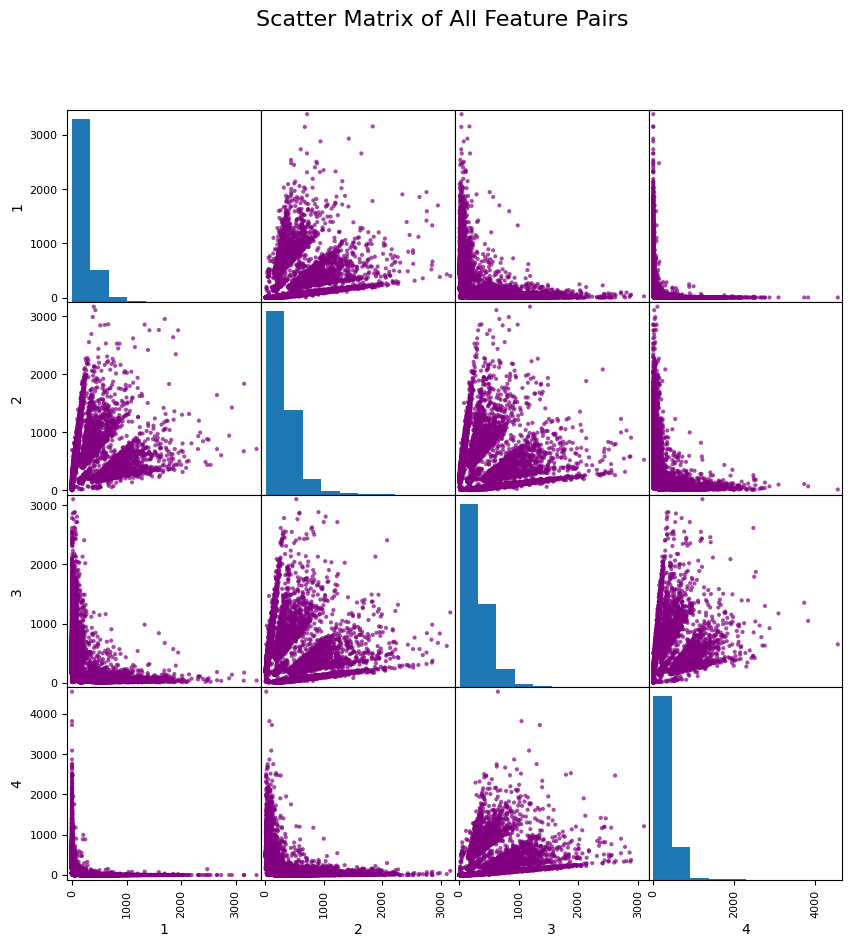

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df = pd.read_csv("public_data.csv")
X = df[['1', '2', '3', '4']]

# Plot pairwise scatter matrix
scatter_matrix(X, figsize=(10, 10), alpha=0.7, diagonal='hist', color='purple')
plt.suptitle("Scatter Matrix of All Feature Pairs", fontsize=16)
plt.show()

## **Clustering**

In [105]:
feature_cols = ['1', '2', '3', '4']
df = pd.read_csv("public_data.csv")
NUM_GROUP = 4 * 4 - 1

**Preprocessing**

In [106]:
# Ratio-Based Features
df['1_div_2'] = df['1'] / (df['2'] + 1e-6)
df['3_div_4'] = df['3'] / (df['4'] + 1e-6)
df['mean_12_div_34'] = (df['1'] + df['2']) / (df['3'] + df['4'] + 1e-6)

# Interaction Terms (Multiplicative)
df['1_mul_2'] = df['1'] * df['2']
df['3_mul_4'] = df['3'] * df['4']
df['1_mul_4'] = df['1'] * df['4']

# Aggregated Additive Features
df['sum_13'] = df['1'] + df['3']
df['sum_14'] = df['1'] + df['4']
df['sum_24'] = df['2'] + df['4']

# Global Statistical Descriptors
df['mean_all'] = df[feature_cols].mean(axis=1)
df['std_all'] = df[feature_cols].std(axis=1)
df['range_all'] = df[feature_cols].max(axis=1) - df[feature_cols].min(axis=1)

new_features = [
    '1_div_2', '3_div_4', 'mean_12_div_34',
    '1_mul_2', '3_mul_4', '1_mul_4',
    'sum_13', 'sum_14', 'sum_24',
    'mean_all', 'std_all', 'range_all'
]

feature_cols += new_features

In [107]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clip to avoid log1p problems
df[feature_cols] = df[feature_cols].clip(lower=-0.999)
df[feature_cols] = np.log1p(df[feature_cols])

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

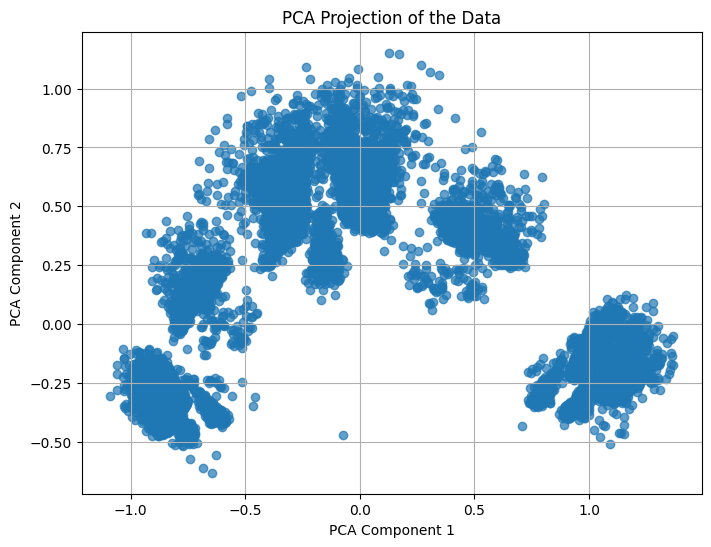

In [29]:
X_pca = pca_plot(df, feature_cols)

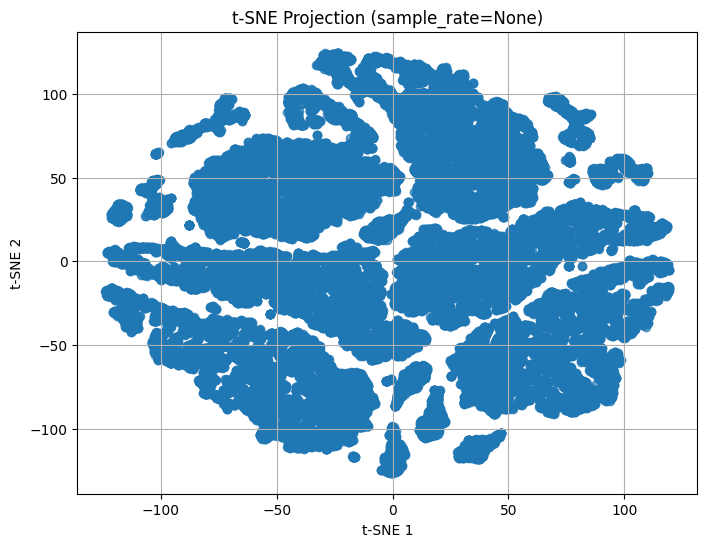

In [30]:
X_tsne = tsne_plot(df, None, feature_cols)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


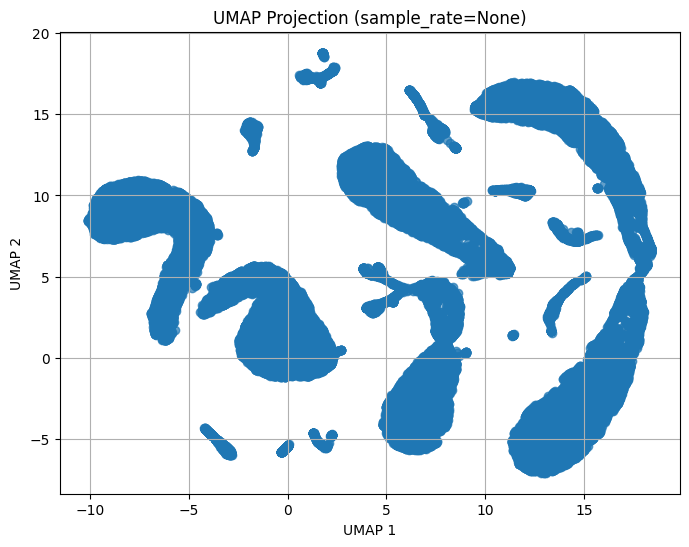

In [31]:
X_umap = umap_plot(df, None, feature_cols)

**KMeans**

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=NUM_GROUP, random_state=42)
df['label'] = kmeans.fit_predict(df)

**DBSCAN**

In [55]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
df['label'] = db.fit_predict(df[feature_cols])

**Hierarchical**

In [47]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=NUM_GROUP)
df['label'] = agg.fit_predict(df[feature_cols])

**Mean Shift**

In [58]:
from sklearn.cluster import MeanShift
ms = MeanShift()
df['label'] = ms.fit_predict(df[feature_cols])

**GMM**

In [108]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=NUM_GROUP, random_state=42)
df['label'] = gmm.fit_predict(df[feature_cols])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df[feature_cols])
print(f"💡 PCA reduced dimensions to: {X_pca.shape[1]}")

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=NUM_GROUP, covariance_type='full', random_state=42)
df['label'] = gmm.fit_predict(X_pca)

💡 PCA reduced dimensions to: 5


**BGMM**

In [74]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=NUM_GROUP, covariance_type='full')
df['label'] = bgmm.fit_predict(df[feature_cols])

**Spectral Clustering**

In [66]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=NUM_GROUP, affinity='nearest_neighbors')
df['label'] = sc.fit_predict(df[feature_cols])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


**Visualization**

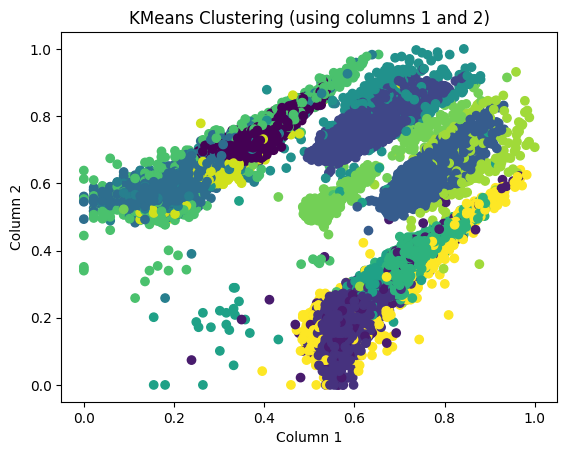

In [ ]:
plt.scatter(df['3'], df['2'], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("KMeans Clustering (using columns 1 and 2)")
plt.show()

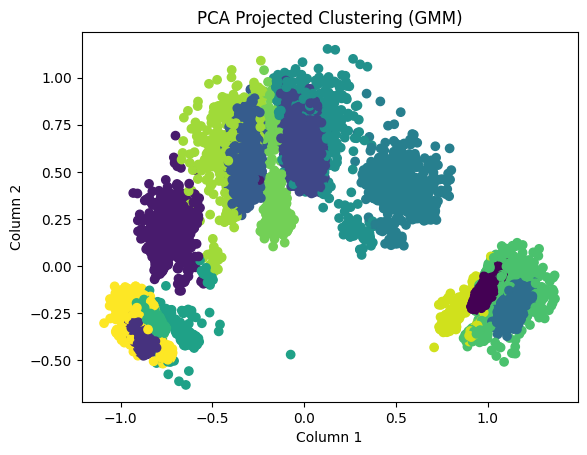

In [77]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("PCA Projected Clustering (GMM)")
plt.show()

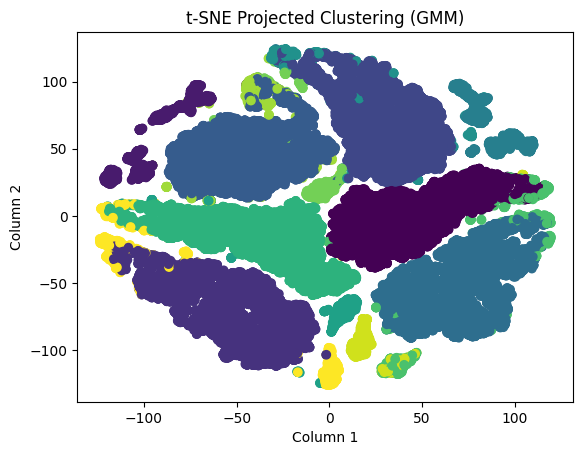

In [78]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("t-SNE Projected Clustering (GMM)")
plt.show()

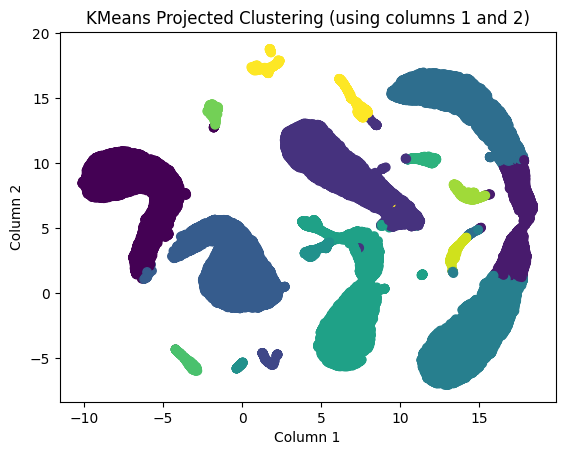

In [70]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("KMeans Projected Clustering (GMM)")
plt.show()

**Evaluation**

In [109]:
from sklearn.metrics import silhouette_score
score = silhouette_score(df[feature_cols], df['label'])
print(f"Silhouette Score (n=15): {score:.4f}")

Silhouette Score (n=15): 0.5672


**Output**

In [114]:
output_df = df[['id', 'label']]
output_df.to_csv("public_submission.csv", index=False)

from google.colab import files
files.download("public_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Main (Private)**

## **Visualization**

**Private Raw**

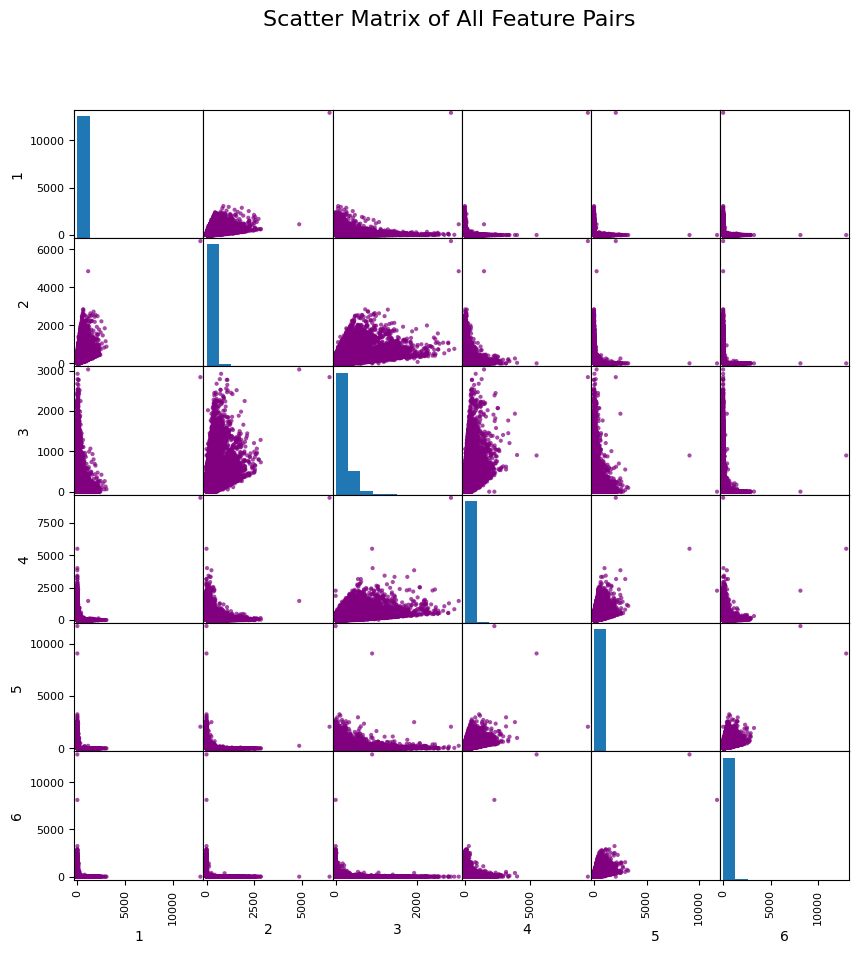

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df = pd.read_csv("private_data.csv")  # Replace with actual path
X = df[['1', '2', '3', '4', '5', '6']]

# Plot pairwise scatter matrix
scatter_matrix(X, figsize=(10, 10), alpha=0.7, diagonal='hist', color='purple')
plt.suptitle("Scatter Matrix of All Feature Pairs", fontsize=16)
plt.show()

## **Clustering**

In [96]:
feature_cols = ['1', '2', '3', '4', '5', '6']
df = pd.read_csv("private_data.csv")
NUM_GROUP = 4 * 6 - 1

**Preprocessing**

In [97]:
# Ratio Features
df['1_div_2'] = df['1'] / (df['2'] + 1e-6)
df['3_div_4'] = df['3'] / (df['4'] + 1e-6)
df['5_div_6'] = df['5'] / (df['6'] + 1e-6)
df['sum_12_div_sum_34'] = (df['1'] + df['2']) / (df['3'] + df['4'] + 1e-6)
df['sum_12_div_sum_56'] = (df['1'] + df['2']) / (df['5'] + df['6'] + 1e-6)

# Multiplicative Interactions
df['1_mul_2'] = df['1'] * df['2']
df['3_mul_4'] = df['3'] * df['4']
df['5_mul_6'] = df['5'] * df['6']
df['1_mul_6'] = df['1'] * df['6']

# Additive Combinations
df['sum_13'] = df['1'] + df['3']
df['sum_24'] = df['2'] + df['4']
df['sum_15'] = df['1'] + df['5']
df['sum_46'] = df['4'] + df['6']

# Statistical Aggregates (across all 6 features)
df['mean_all'] = df[feature_cols].mean(axis=1)
df['std_all'] = df[feature_cols].std(axis=1)
df['range_all'] = df[feature_cols].max(axis=1) - df[feature_cols].min(axis=1)
df['skew_all'] = df[feature_cols].skew(axis=1)


new_features = [
    '1_div_2', '3_div_4', '5_div_6', 'sum_12_div_sum_34', 'sum_12_div_sum_56',
    '1_mul_2', '3_mul_4', '5_mul_6', '1_mul_6',
    'sum_13', 'sum_24', 'sum_15', 'sum_46',
    'mean_all', 'std_all', 'range_all', 'skew_all'
]
feature_cols += new_features

In [98]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clip to avoid log1p problems
df[feature_cols] = df[feature_cols].clip(lower=-0.999)
df[feature_cols] = np.log1p(df[feature_cols])

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

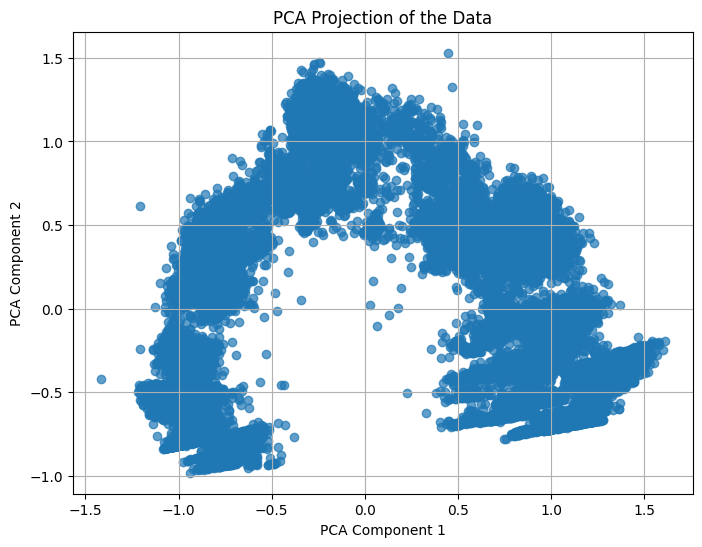

In [89]:
X_pca = pca_plot(df, feature_cols)

In [ ]:
X_tsne = tsne_plot(df, None, feature_cols)

In [ ]:
X_umap = umap_plot(df, None, feature_cols)

**KMeans**

In [90]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=NUM_GROUP, random_state=42)
df['label'] = kmeans.fit_predict(df)

**DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
df['label'] = db.fit_predict(df[feature_cols])

**Hierarchical**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=NUM_GROUP)
df['label'] = agg.fit_predict(df[feature_cols])

**Mean Shift**

In [ ]:
from sklearn.cluster import MeanShift
ms = MeanShift()
df['label'] = ms.fit_predict(df[feature_cols])

**GMM**

In [99]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=NUM_GROUP, random_state=42)
df['label'] = gmm.fit_predict(df[feature_cols])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df[feature_cols])
print(f"💡 PCA reduced dimensions to: {X_pca.shape[1]}")

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=NUM_GROUP, covariance_type='full', random_state=42)
df['label'] = gmm.fit_predict(X_pca)

💡 PCA reduced dimensions to: 5


**BGMM**

In [73]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=NUM_GROUP, covariance_type='full')
df['label'] = bgmm.fit_predict(df[feature_cols])

**Spectral Clustering**

In [ ]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=NUM_GROUP, affinity='nearest_neighbors')
df['label'] = sc.fit_predict(df[feature_cols])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


**Visualization**

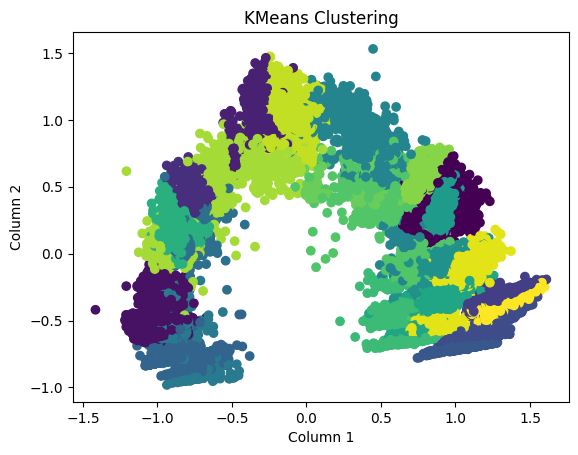

In [93]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("KMeans Clustering")
plt.show()

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("KMeans Clustering (using columns 1 and 2)")
plt.show()

In [ ]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['label'], cmap='viridis')
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.title("KMeans Clustering (using columns 1 and 2)")
plt.show()

**Evaluation**

In [94]:
from sklearn.metrics import silhouette_score
score = silhouette_score(df[feature_cols], df['label'])
print(f"Silhouette Score (n={NUM_GROUP}): {score:.4f}")

Silhouette Score (n=23): 0.5272


**Output**

In [95]:
output_df = df[['id', 'label']]
output_df.to_csv("private_submission.csv", index=False)

from google.colab import files
files.download("private_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>